In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.argv=['']
del sys
os.chdir("../")

In [279]:
import matplotlib.pyplot as plt
import os
import json
import math
import torch
import logging
import numpy as np
import pandas as pd

from IPython import embed
from common import data_preprocess 
from common.utils import print_to_json, iter_thresholds
from common.dataloader import load_dataset
from common.sliding import WindowIterator
from common.config import parse_arguments, set_logger, initialize_config
from networks.mlstm import MultiLSTMEncoder
from torch import nn
%matplotlib inline

In [359]:
# train
args = parse_arguments()

# load config
config_dir = "./hypers/" if not args["load"] else args["load"]
params = initialize_config(config_dir, args)
params["clear"] = 1
params["nrows"] = None
params["inter"] = "CONCAT"
params["window_size"] = 64

In [360]:
data_dict = load_dataset("SMD","machine-1-1", use_dim="all")
# data_dict["train"].max(), data_dict["train"].min()

2021-02-21 21:40:59,691 P18958 INFO Loading machine-1-1 of SMD dataset
2021-02-21 21:40:59,693 P18958 INFO 1 files found.


In [361]:
pp = data_preprocess.preprocessor()
pp.save(params["save_path"])
data_dict = pp.normalize(data_dict,method="minmax")
window_dict = data_preprocess.generate_windows(data_dict, data_hdf5_path=params["path"], **params)

2021-02-21 21:40:59,874 P18958 INFO Saving preprocessor into ./checkpoints/20210221-214059/preprocessor.pkl
2021-02-21 21:40:59,876 P18958 INFO Normalizing data
2021-02-21 21:40:59,898 P18958 INFO Generating sliding windows (size 64).
2021-02-21 21:41:00,119 P18958 INFO Train windows #: (5683, 64, 38)
2021-02-21 21:41:00,120 P18958 INFO Test windows #: (28415, 64, 38)


In [362]:
data_dict["train"].max(), data_dict["train"].min(), data_dict["test"].max(), data_dict["test"].min()

(1.0, 0.0, 1.0, 0.0)

In [363]:
window_dict["train_windows"].shape

(5683, 64, 38)

In [364]:
train_iterator = WindowIterator(window_dict["train_windows"], batch_size=params["batch_size"], shuffle=True)
test_iterator = WindowIterator(window_dict["test_windows"], batch_size=params["batch_size"], shuffle=False)
params['in_channels'] = data_dict["dim"]

In [390]:
params["nb_steps"] = 100
encoder = MultiLSTMEncoder(**params)

2021-02-21 22:19:07,699 P18958 INFO Compiling finished.


In [391]:
# training
encoder.fit(
            train_iterator,
            test_iterator=test_iterator.loader,
            test_labels=None,
            **params
        )
encoder.save_encoder()

2021-02-21 22:19:08,153 P18958 INFO Start training for 89 batches.
2021-02-21 22:19:08,592 P18958 INFO Epoch: 1, loss: 35.99196
2021-02-21 22:19:09,041 P18958 INFO Epoch: 2, loss: 11.43364
2021-02-21 22:19:09,508 P18958 INFO Epoch: 3, loss: 8.90492
2021-02-21 22:19:09,944 P18958 INFO Epoch: 4, loss: 7.58410
2021-02-21 22:19:10,354 P18958 INFO Epoch: 5, loss: 7.26003
2021-02-21 22:19:10,779 P18958 INFO Epoch: 6, loss: 6.70743
2021-02-21 22:19:11,352 P18958 INFO Epoch: 7, loss: 6.16490
2021-02-21 22:19:11,993 P18958 INFO Epoch: 8, loss: 5.68028
2021-02-21 22:19:12,621 P18958 INFO Epoch: 9, loss: 5.42390
2021-02-21 22:19:13,034 P18958 INFO Epoch: 10, loss: 5.16818
2021-02-21 22:19:13,464 P18958 INFO Epoch: 11, loss: 5.11100
2021-02-21 22:19:13,876 P18958 INFO Epoch: 12, loss: 5.05881
2021-02-21 22:19:14,286 P18958 INFO Epoch: 13, loss: 4.76728
2021-02-21 22:19:14,709 P18958 INFO Epoch: 14, loss: 4.69705
2021-02-21 22:19:15,219 P18958 INFO Epoch: 15, loss: 4.54705
2021-02-21 22:19:15,770 P

KeyboardInterrupt: 

In [301]:
encoder.load_encoder()

2021-02-21 21:29:33,565 P18958 INFO Loading model from ./checkpoints/20210221-212825/MultiLSTM__20210221-212825.pth


2021-02-21 21:22:33,208 P18958 INFO Evaluating
2021-02-21 21:22:40,359 P18958 INFO AUC: 0.949, F1: 0.058(0.999), PS: 0.030(1.000), RC:0.942(0.998)


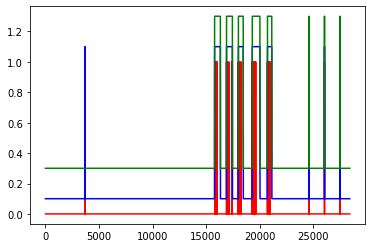

In [261]:
# test_labels = window_dict["test_labels"][:, -1]
score_dict = encoder.score(test_iterator.loader, window_dict["test_labels"])
best_f1, best_theta, best_adjust, best_raw = iter_thresholds(
            score_dict["score"], score_dict["anomaly_label"]
        )
plt.plot(best_raw, "r")
plt.plot(best_adjust + 0.1, "b")
plt.plot(score_dict["anomaly_label"]+0.3, "g")
# plt.plot(score_dict["score"], "g")

In [392]:
# def reconstruction_loader(loader, encoder):
train_iterator_non_shuffle = WindowIterator(window_dict["train_windows"],
                                            batch_size=params["batch_size"], shuffle=False)
loader = train_iterator_non_shuffle.loader

loader = test_iterator.loader
encoder = encoder.eval()
with torch.no_grad():
    recst_list = []
    real_list = []
    loss = 0
    for batch in loader:
        batch = batch.to(encoder.device)
        return_dict = encoder(batch)
        # diff = return_dict["diff"].max(dim=-1)[0] # chose the most anomaous ts
        recst = return_dict["recst"]  # chose the most anomaous ts
        recst_list.append(recst)
        real_list.append(return_dict["y"])
        loss += return_dict["loss"].item()
print(loss / len(loader))
recst_list = torch.cat(recst_list).squeeze()
real_list = torch.cat(real_list).squeeze()
diff_list = (recst_list - real_list).sigmoid()
recst_list = recst_list.cpu().numpy()
real_list = real_list.cpu().numpy()

19.915703976745004


In [388]:
print(recst_list.shape)
print(real_list.shape)
print(diff_list.shape)
print(window_dict["test_labels"].shape)

(28415, 38)
(28415, 38)
torch.Size([28415, 38])
(28415, 64)


In [382]:
real_list.min(), real_list.max(), recst_list.min(), recst_list.max()

(0.0, 1.0, -0.014802128, 1.3355678)

In [372]:
window_dict["test_labels"].shape

(28415, 64)

In [ ]:
dims = [9, 13, 14, 15]
fig, ax = plt.subplots(nrows=len(dims)+1, sharey=True, figsize=(12,12))
i=0
# ax[0].plot(recst, 'r', label='reconstruction')
# ax[0].legend(loc='best')
for i in range(len(dims)):
    j = dims[i] 
    ax[i].plot(recst_list[0:, j].reshape(-1), 'r', label='recst')
    ax[i].plot(real_list[0:, j].reshape(-1), 'b', label='real')
    ax[i].plot(diff_list[0:, j].reshape(-1)-1, 'g', label='score')
    ax[i].plot(window_dict["test_labels"][0:, -1].reshape(-1)-2, 'r', label='label')
    ax[i].legend(loc='best')
ax[-1].plot(diff_list.max(axis=-1))
# ax[1].legend(loc='best')

plt.legend()
plt.suptitle("Result of the autoencoder")
plt.show()

ValueError: only one element tensors can be converted to Python scalars

In [29]:
names=["time", "expid", "dataset", "auc", "f1", "f1a"]
df = pd.read_csv("./experiment_results.csv", sep="\t", names=names)

In [30]:
df["f1a"].map(lambda x: float(x.split("-")[1])).mean()

0.9235357142857143